<a href="https://colab.research.google.com/github/DanielleJTaylor/PythonDT/blob/main/Phishing_Detection_CPS499_Cybersecruity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project by Alex Torres and Danielle Taylor

In [ ]:
!pip install tensorflow keras keras-preprocessing # Install all required packages in one cell

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
#from keras.preprocessing.text import Tokenizer # Now you should be able to import this
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
import nltk
#nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix,mean_squared_error,precision_score,recall_score,f1_score
from sklearn.metrics import classification_report , roc_curve, f1_score, accuracy_score, recall_score , roc_auc_score,make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 783.5 kB/s eta 0:00:00


In [ ]:
# the phishing URL dataset is from kaggle:
# https://www.kaggle.com/code/mohamedgalal1/phishing-detection-using-ml-techniques/data

# I saved here for you:
# https://drive.google.com/file/d/13K9_OFtfq8ksSWfy6nYZjBmK-12EUyVX/view?usp=sharing

from google.colab import files
df= pd.read_csv("/content/phishing_site_urls.csv")
print(df.head()) # print top five rows
print(df.shape) # print dataset size: (# of rows, # of columns)

                                                 URL Label
0  nobell.it/70ffb52d079109dca5664cce6f317373782/...   bad
1  www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...   bad
2  serviciosbys.com/paypal.cgi.bin.get-into.herf....   bad
3  mail.printakid.com/www.online.americanexpress....   bad
4  thewhiskeydregs.com/wp-content/themes/widescre...   bad
(549346, 2)


<ipython-input-5-130d6cb70dc6>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y=np.array([df[df['Label']=='bad'].count()[0],df[df['Label']=='good'].count()[0]])
<ipython-input-5-130d6cb70dc6>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y=np.array([df[df['Label']=='bad'].count()[0],df[df['Label']=='good'].count()[0]])


<BarContainer object of 2 artists>

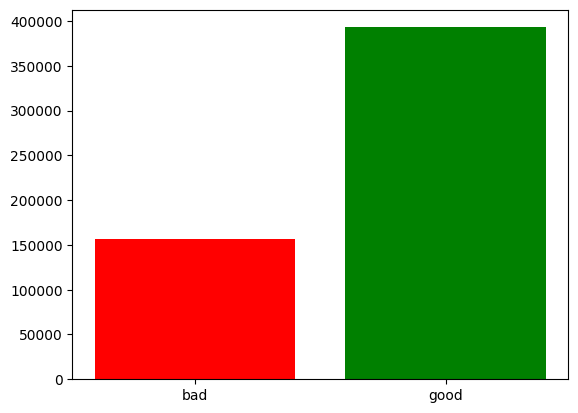

In [ ]:
x=df.Label.unique()
x
y=np.array([df[df['Label']=='bad'].count()[0],df[df['Label']=='good'].count()[0]])
y

plt.bar(x,y,color=[ 'red', 'green'])

In [ ]:
df.drop(df[df.URL.duplicated() == True].index, axis = 0, inplace = True)
df.reset_index(drop=True)

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad
...,...,...
507190,23.227.196.215/,bad
507191,apple-checker.org/,bad
507192,apple-iclods.org/,bad
507193,apple-uptoday.org/,bad


In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
print(stopwords.words('english'))
sw=list(set(stopwords.words("english")))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df['clean_url']=df.URL.astype(str)
#df['clean_url']=df['clean_url'].apply(lambda x:" ".join([word for word in x.split() if word not in sw]))
df.head()

,URL,Label,clean_url
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,nobell.it/70ffb52d079109dca5664cce6f317373782/...
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,serviciosbys.com/paypal.cgi.bin.get-into.herf....
3,mail.printakid.com/www.online.americanexpress....,bad,mail.printakid.com/www.online.americanexpress....
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,thewhiskeydregs.com/wp-content/themes/widescre...


In [ ]:
tok= RegexpTokenizer(r'[A-Za-z0-9]+')
tok.tokenize(df.URL[1])

['www',
 'dghjdgf',
 'com',
 'paypal',
 'co',
 'uk',
 'cycgi',
 'bin',
 'webscrcmd',
 'home',
 'customer',
 'nav',
 '1',
 'loading',
 'php']

In [ ]:
df.clean_url=df.clean_url.map(lambda x: tok.tokenize(x))
df.head()

,URL,Label,clean_url
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,"[nobell, it, 70ffb52d079109dca5664cce6f3173737..."
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,"[www, dghjdgf, com, paypal, co, uk, cycgi, bin..."
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,"[serviciosbys, com, paypal, cgi, bin, get, int..."
3,mail.printakid.com/www.online.americanexpress....,bad,"[mail, printakid, com, www, online, americanex..."
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,"[thewhiskeydregs, com, wp, content, themes, wi..."


In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')
wnl = WordNetLemmatizer()
df['lem_url'] = df['clean_url'].map(lambda x: [wnl.lemmatize(word) for word in x])
df.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


,URL,Label,clean_url,lem_url
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,"[nobell, it, 70ffb52d079109dca5664cce6f3173737...","[nobell, it, 70ffb52d079109dca5664cce6f3173737..."
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,"[www, dghjdgf, com, paypal, co, uk, cycgi, bin...","[www, dghjdgf, com, paypal, co, uk, cycgi, bin..."
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,"[serviciosbys, com, paypal, cgi, bin, get, int...","[serviciosbys, com, paypal, cgi, bin, get, int..."
3,mail.printakid.com/www.online.americanexpress....,bad,"[mail, printakid, com, www, online, americanex...","[mail, printakid, com, www, online, americanex..."
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,"[thewhiskeydregs, com, wp, content, themes, wi...","[thewhiskeydregs, com, wp, content, theme, wid..."


In [ ]:
df.isna().sum()

,0
URL,0
Label,0
clean_url,0
lem_url,0


In [ ]:
word_vectorizer = TfidfVectorizer(ngram_range=(1,1), max_features =1000)

unigramdataGet= word_vectorizer.fit_transform(df['lem_url'].astype('str'))
unigramdataGet = unigramdataGet.toarray()
vocab = word_vectorizer.get_feature_names_out ()
x=pd.DataFrame(np.round(unigramdataGet, 1), columns=vocab)
x[x>0] = 1

In [ ]:
x

,00,0001,01,02,03,04,05,06,07,08,...,yelp,york,you,young,your,youtube,za,zimbio,zip,zoominfo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
507191,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
507192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
507193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
cv = CountVectorizer()
feature = cv.fit_transform(df.lem_url.astype('str'))
feature

<507195x482937 sparse matrix of type '<class 'numpy.int64'>'
	with 3549251 stored elements in Compressed Sparse Row format>

In [ ]:
y=df.Label
y=np.where(y=='bad',0,1)


In [ ]:
x_train,x_test,y_train,y_test =  train_test_split(feature,y,random_state=42,test_size=0.2,shuffle=True)

In [ ]:
def get_accuracy(name, trained_model , x_train, y_train, x_test, y_test):
    tree_predict = trained_model.predict(x_test)
    print("Testing accuracy   :",metrics.accuracy_score(y_test, tree_predict)*100 , "%")
    print("MSE [TEST]          :",mean_squared_error(y_test, tree_predict))


    tree_predict1 = trained_model.predict(x_train)
    print("Training accuracy  :",metrics.accuracy_score(y_train, tree_predict1)*100 ,"%")
    print("MSE [TRAIN]         :",mean_squared_error(y_train, tree_predict1))

    print("precision : ",precision_score(y_test, tree_predict,average='micro'))
    print("recall    : ",recall_score(y_test, tree_predict,average='micro'))
    print("f1_score  : ",f1_score(y_test, tree_predict,average='micro'))


    cf1 = confusion_matrix(y_test,tree_predict)
    sb.heatmap(cf1,annot=True,fmt = '.0f')
    plt.xlabel('prediction')
    plt.ylabel('Actual')
    plt.title(name+ ' Confusion Matrix')
    plt.show()

    print(classification_report(y_train,  trained_model.predict(x_train)))
    print(classification_report(y_test,  trained_model.predict(x_test)))

Testing accuracy   : 96.14940999024044 %
MSE [TEST]          : 0.0385059000975956
Training accuracy  : 98.10846912923039 %
MSE [TRAIN]         : 0.01891530870769625
precision :  0.9614940999024044
recall    :  0.9614940999024044
f1_score  :  0.9614940999024044


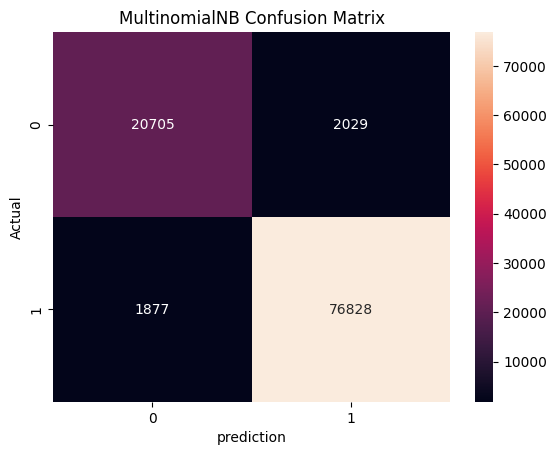

              precision    recall  f1-score   support

           0       0.97      0.95      0.96     91564
           1       0.98      0.99      0.99    314192

    accuracy                           0.98    405756
   macro avg       0.98      0.97      0.97    405756
weighted avg       0.98      0.98      0.98    405756

              precision    recall  f1-score   support

           0       0.92      0.91      0.91     22734
           1       0.97      0.98      0.98     78705

    accuracy                           0.96    101439
   macro avg       0.95      0.94      0.94    101439
weighted avg       0.96      0.96      0.96    101439



In [ ]:
trained_clf_multinomial_nb = MultinomialNB().fit(x_train, y_train)
get_accuracy('MultinomialNB',trained_clf_multinomial_nb,x_train, y_train, x_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Testing accuracy   : 96.34755863129566 %
MSE [TEST]          : 0.03652441368704344
Training accuracy  : 97.84328512702216 %
MSE [TRAIN]         : 0.02156714872977849
precision :  0.9634755863129566
recall    :  0.9634755863129566
f1_score  :  0.9634755863129566


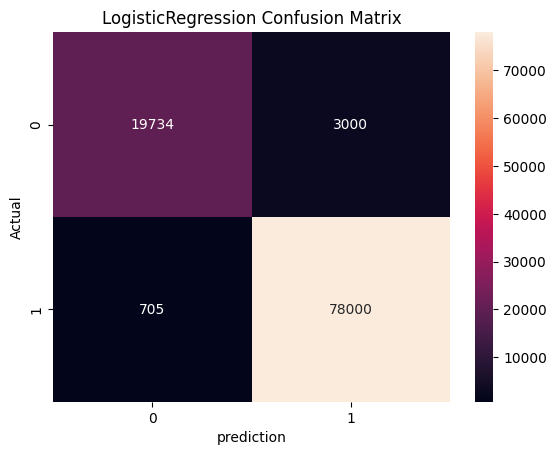

              precision    recall  f1-score   support

           0       0.99      0.92      0.95     91564
           1       0.98      1.00      0.99    314192

    accuracy                           0.98    405756
   macro avg       0.98      0.96      0.97    405756
weighted avg       0.98      0.98      0.98    405756

              precision    recall  f1-score   support

           0       0.97      0.87      0.91     22734
           1       0.96      0.99      0.98     78705

    accuracy                           0.96    101439
   macro avg       0.96      0.93      0.95    101439
weighted avg       0.96      0.96      0.96    101439



In [ ]:
trained_clf_LogisticRegression = LogisticRegression().fit(x_train, y_train)
get_accuracy('LogisticRegression',trained_clf_LogisticRegression,x_train, y_train, x_test, y_test)

Testing accuracy   : 97.1381815672473 %
MSE [TEST]          : 0.02861818432752689
Training accuracy  : 99.96475714468794 %
MSE [TRAIN]         : 0.00035242855312059464
precision :  0.9713818156724731
recall    :  0.9713818156724731
f1_score  :  0.9713818156724731


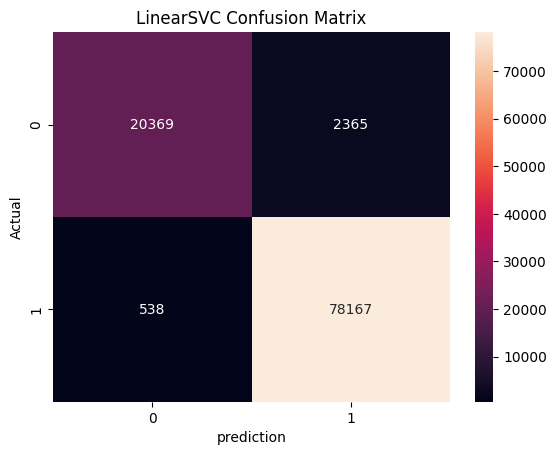

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     91564
           1       1.00      1.00      1.00    314192

    accuracy                           1.00    405756
   macro avg       1.00      1.00      1.00    405756
weighted avg       1.00      1.00      1.00    405756

              precision    recall  f1-score   support

           0       0.97      0.90      0.93     22734
           1       0.97      0.99      0.98     78705

    accuracy                           0.97    101439
   macro avg       0.97      0.94      0.96    101439
weighted avg       0.97      0.97      0.97    101439



In [ ]:
from sklearn.svm import LinearSVC
trained_clf_svc = LinearSVC().fit(x_train, y_train)
get_accuracy('LinearSVC',trained_clf_svc,x_train, y_train, x_test, y_test)

In [ ]:
# Feature extraction functions
def has_ip_address(url):
    """Check if the URL has an IP address."""
    ip_pattern = r'(?:(?:\d{1,3}\.){3}\d{1,3})'
    return 1 if re.search(ip_pattern, url) else 0

def count_dots(url):
    """Count the number of dots in the URL."""
    return url.count('.')

def url_length(url):
    """Return the length of the URL."""
    return len(url)

def domain_age(url):
    """Get the age of the domain name in years."""
    domain = urlparse(url).netloc
    try:
        whois_info = whois.whois(domain)
        creation_date = whois_info.creation_date
        if isinstance(creation_date, list):
            creation_date = creation_date[0]  # Handle cases where it's a list
        if creation_date:
            age = (pd.Timestamp.now() - pd.Timestamp(creation_date)).days / 365
            return age if age >= 0 else 0  # Return 0 if the date is in the future
    except Exception as e:
        return 0  # If WHOIS query fails, assume age is 0
    return 0

def has_redirection(url):
    """Check if the URL has a redirection script."""
    return 1 if 'redirect' in url else 0

def contains_javascript(url):
    """Check if the URL contains JavaScript."""
    return 1 if 'javascript' in url else 0

# Apply feature extraction
df['has_ip'] = df['URL'].apply(has_ip_address)
df['num_dots'] = df['URL'].apply(count_dots)
df['url_length'] = df['URL'].apply(url_length)
df['domain_age'] = df['URL'].apply(domain_age)
df['has_redirection'] = df['URL'].apply(has_redirection)
df['contains_javascript'] = df['URL'].apply(contains_javascript)

# For your own feature idea (example: the presence of suspicious keywords)
def contains_suspicious_keywords(url):
    """Check for suspicious keywords in the URL."""
    suspicious_keywords = ['login', 'secure', 'account', 'update', 'verify']
    return 1 if any(keyword in url.lower() for keyword in suspicious_keywords) else 0

df['contains_suspicious'] = df['URL'].apply(contains_suspicious_keywords)

# Print the updated DataFrame with features
print(df.head())

NameError: name 're' is not defined